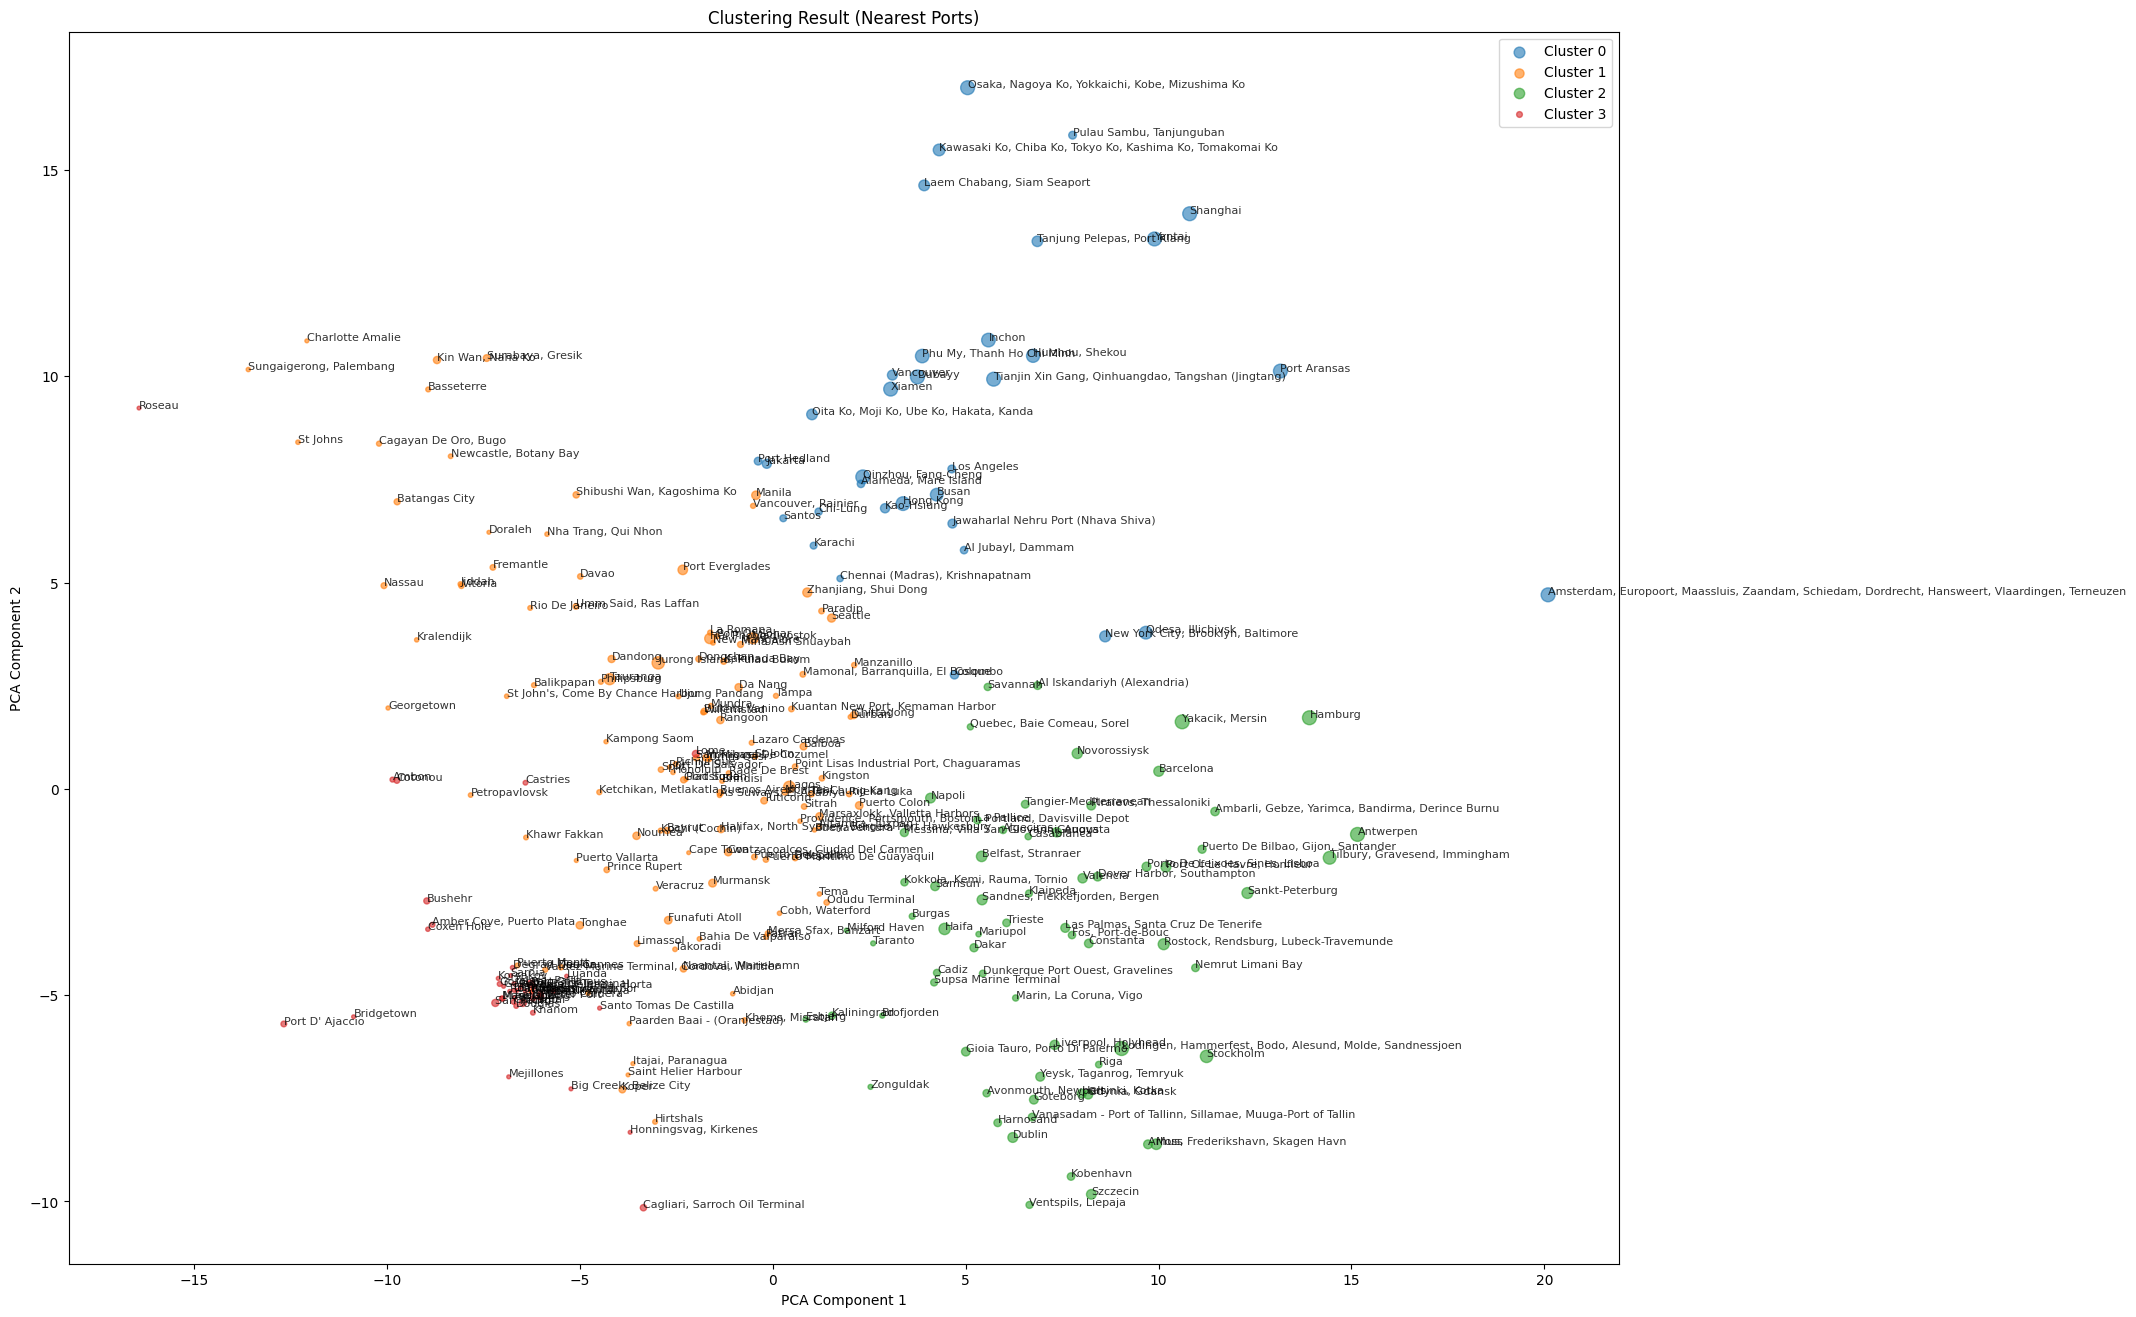

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
n_clusters = 4

# 1. 加载节点的地理信息
clusters = pd.read_feather('result/clusters/cl_01-03.feather')

# 2. 加载节点嵌入数据
node_embeddings = pd.read_csv('result/graph_embedding/nodeembs_epoch-30.csv', header=None)
node_embeddings = node_embeddings.values[:, 1:]  # 将数据转换为NumPy数组，并去除第一列（第一列是标签，不参与拟合）

if node_embeddings.shape[0] < clusters.shape[0]: # 如果节点嵌入数据的行数不足 clusters 的行数，则补充缺失的部分
    n_needed = clusters.shape[0] - node_embeddings.shape[0]
    # 获取嵌入向量的维度
    d = node_embeddings.shape[1]
    # 生成随机向量（服从标准正态分布），并对每一行归一化，使其模长为1
    random_vectors = np.random.randn(n_needed, d)
    norms = np.linalg.norm(random_vectors, axis=1, keepdims=True)
    random_vectors = random_vectors / norms
    # 将生成的随机向量追加到原有的 node_embeddings 后面
    node_embeddings = np.vstack([node_embeddings, random_vectors])

# 3. 对节点嵌入进行标准化
scaler = StandardScaler()
node_embeddings_scaled = scaler.fit_transform(node_embeddings)

# 4. 使用KMeans对节点嵌入进行聚类
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
clusters['cluster'] = kmeans.fit_predict(node_embeddings_scaled)

# 5. 进行PCA降维，以便进行可视化
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(node_embeddings_scaled)

# 6. 将PCA降维结果添加到clusters数据框中
clusters['pca_x'] = reduced_embeddings[:, 0]
clusters['pca_y'] = reduced_embeddings[:, 1]

# 7. 绘制聚类结果
plt.figure(figsize=(20, 16))
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(n_clusters)]

# 遍历每个聚类类别
for cl in sorted(clusters['cluster'].unique()):
    sub_df = clusters[clusters['cluster'] == cl]
    plt.scatter(sub_df['pca_x'], sub_df['pca_y'], 
                s=np.sqrt(sub_df['ship_cnts']),
                color=colors[cl % len(colors)], 
                label=f'Cluster {cl}', alpha=0.6)
    # 对每个点添加 nearest_ports 标签
    for idx, row in sub_df.iterrows():
        plt.annotate(row['nearest_ports'], (row['pca_x'], row['pca_y']), fontsize=8, alpha=0.8)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering Result (Nearest Ports)')
plt.legend()
plt.show()


/tmp/ipykernel_2032948/1325422937.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clusters['centroid'] = clusters.geometry.centroid
/tmp/ipykernel_2032948/1325422937.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clusters['centroid_lon'] = clusters.centroid.x
/tmp/ipykernel_2032948/1325422937.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clusters['centroid_lat'] = clusters.centroid.y


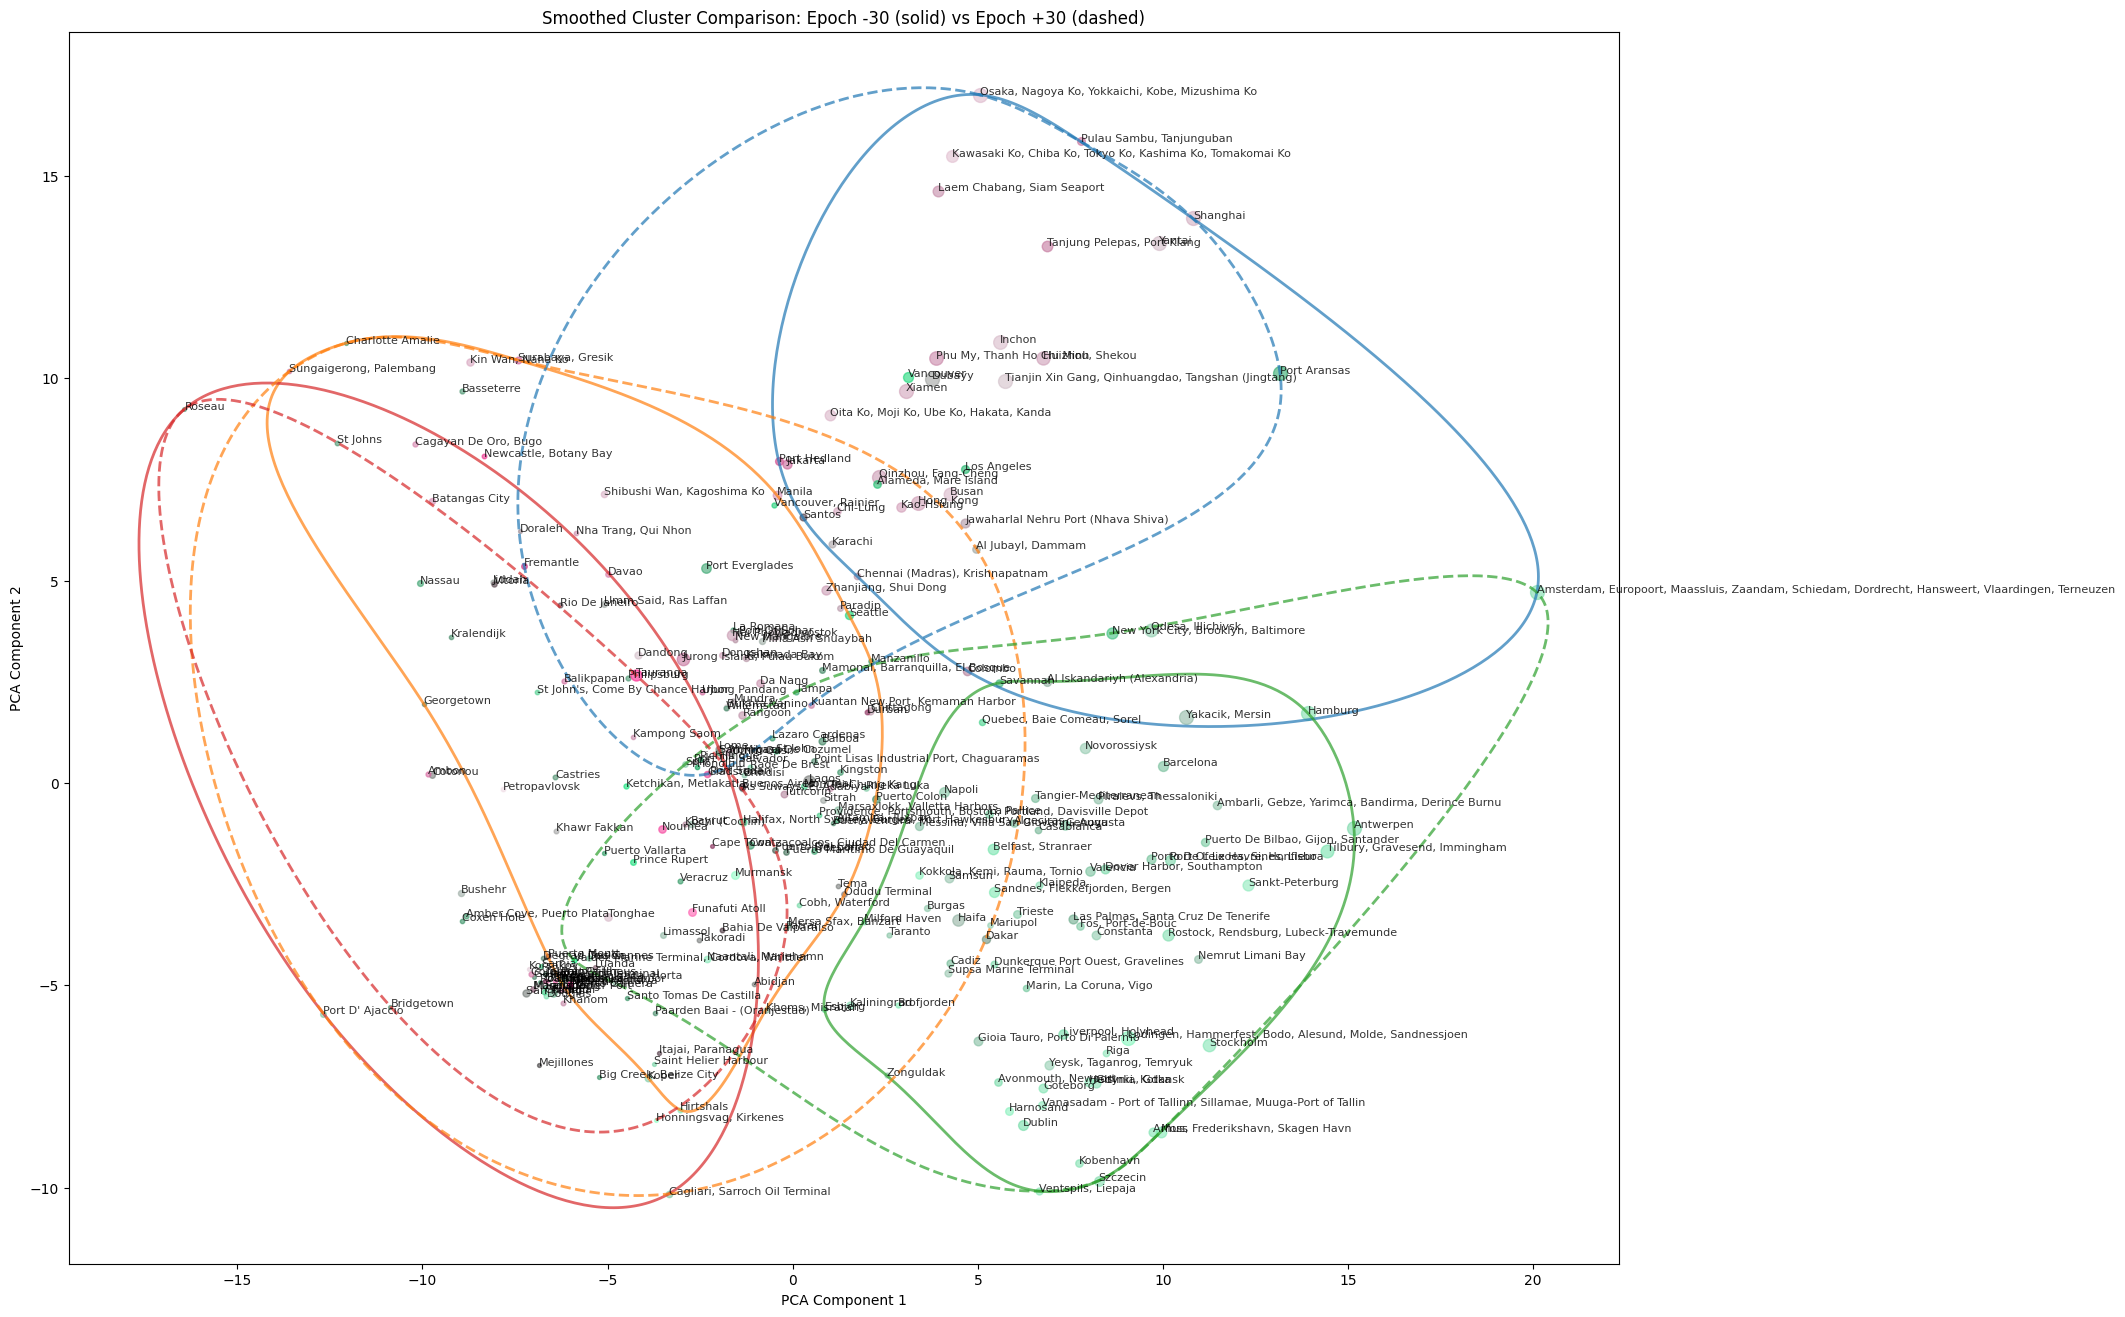

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
from scipy.optimize import linear_sum_assignment
from matplotlib.colors import Normalize

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
n_clusters = 4

# 加载节点的地理信息
clusters = gpd.read_feather('result/clusters/cl_01-03.feather')

clusters['centroid'] = clusters.geometry.centroid
clusters['centroid_lon'] = clusters.centroid.x
clusters['centroid_lat'] = clusters.centroid.y

# 加载两个时间点的节点嵌入数据
emb_before = pd.read_csv('result/graph_embedding/nodeembs_epoch-30.csv', header=None).values[:, 1:]
emb_after = pd.read_csv('result/graph_embedding/nodeembs_epoch+30.csv', header=None).values[:, 1:]

# 对齐节点数
def pad_embeddings(emb, target_len):
    if emb.shape[0] < target_len:
        n_needed = target_len - emb.shape[0]
        d = emb.shape[1]
        random_vectors = np.random.randn(n_needed, d)
        norms = np.linalg.norm(random_vectors, axis=1, keepdims=True)
        random_vectors = random_vectors / norms
        emb = np.vstack([emb, random_vectors])
    return emb

emb_before = pad_embeddings(emb_before, clusters.shape[0])
emb_after = pad_embeddings(emb_after, clusters.shape[0])

# 标准化
scaler = StandardScaler()
emb_before_scaled = scaler.fit_transform(emb_before)
emb_after_scaled = scaler.fit_transform(emb_after)

# 聚类
kmeans_before = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED).fit(emb_before_scaled)
kmeans_after = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED).fit(emb_after_scaled)

# PCA（以 before 的为准）
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(emb_before_scaled)

clusters['pca_x'] = pca_coords[:, 0]
clusters['pca_y'] = pca_coords[:, 1]
clusters['cluster_before'] = kmeans_before.labels_
clusters['cluster_after'] = kmeans_after.labels_

# 使用 Hungarian algorithm 对齐 cluster label
intersection = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        intersection[i, j] = np.sum((clusters['cluster_before'] == i) & (clusters['cluster_after'] == j))
row_ind, col_ind = linear_sum_assignment(-intersection)  # maximize intersection
color_map = dict(zip(col_ind, row_ind))  # after_cluster -> before_cluster color

# 可视化
plt.figure(figsize=(20, 16))

cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(n_clusters)]

norm_x = Normalize(vmin=clusters['centroid_lon'].min(), vmax=clusters['centroid_lon'].max())
norm_y = Normalize(vmin=clusters['centroid_lat'].min(), vmax=clusters['centroid_lat'].max())
colors_point = np.array([[norm_x(x), norm_y(y), (norm_x(x) + norm_y(y)) / 2] for x, y in zip(clusters['centroid_lon'], clusters['centroid_lat'])])

# 绘制散点图和标签
for idx, row in clusters.iterrows():
    plt.scatter(row['pca_x'], row['pca_y'], s=np.sqrt(row['ship_cnts']), color=colors_point[idx], alpha=0.6)
    plt.annotate(row['nearest_ports'], (row['pca_x'], row['pca_y']), fontsize=8, alpha=0.8)

# 函数：绘制平滑凸包
def plot_smoothed_hull(points, color, linestyle):
    if len(points) < 3:
        return
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_points = np.concatenate([hull_points, hull_points[:1]], axis=0)  # close loop
    tck, _ = splprep([hull_points[:, 0], hull_points[:, 1]], s=0, per=True)
    u_fine = np.linspace(0, 1, 400)
    x_fine, y_fine = splev(u_fine, tck)
    plt.plot(x_fine, y_fine, color=color, linestyle=linestyle, linewidth=2, alpha=0.7)

# 绘制聚类凸包（before）
for i in range(n_clusters):
    points = clusters[clusters['cluster_before'] == i][['pca_x', 'pca_y']].values
    plot_smoothed_hull(points, color=colors[i], linestyle='-')

# 绘制聚类凸包（after，映射颜色）
for j in range(n_clusters):
    mapped_color = colors[color_map[j]]
    points = clusters[clusters['cluster_after'] == j][['pca_x', 'pca_y']].values
    plot_smoothed_hull(points, color=mapped_color, linestyle='--')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Smoothed Cluster Comparison: Epoch -30 (solid) vs Epoch +30 (dashed)')
plt.show()

# 保存包含原始信息 + 聚类标签的表格
output_df = clusters[['label', 'geometry', 'ship_cnts', 'country_water_body', 'nearest_ports', 'cluster_before', 'cluster_after']]

# 保存为 CSV
output_df.to_csv('result/graph_embedding/cluster_comparison.csv', index=False)